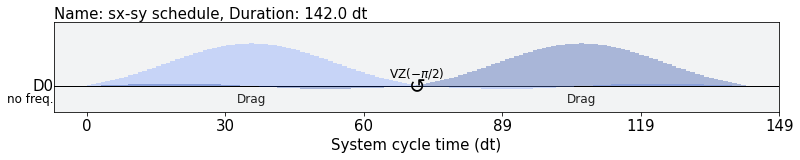

In [1]:
import numpy as np
import qiskit.pulse as pulse

# Strength of the Rabi-rate in GHz.
r = 0.1

# Frequency of the qubit transition in GHz.
w = 5.

# Sample rate of the backend in ns.
dt = 0.222

# Define gaussian envelope function to have a pi rotation.
amp = 1.
area = 1
sig = area*0.399128/r/amp
T = 4*sig
duration = int(T / dt)
beta = 2.0

# The 1.75 factor is used to approximately get a sx gate.
# Further "calibration" could be done to refine the pulse amplitude.
with pulse.build(name="sx-sy schedule") as xp:
    pulse.play(pulse.Drag(duration, amp / 1.75, sig / dt, beta), pulse.DriveChannel(0))
    pulse.shift_phase(np.pi/2, pulse.DriveChannel(0))
    pulse.play(pulse.Drag(duration, amp / 1.75, sig / dt, beta), pulse.DriveChannel(0))

xp.draw()

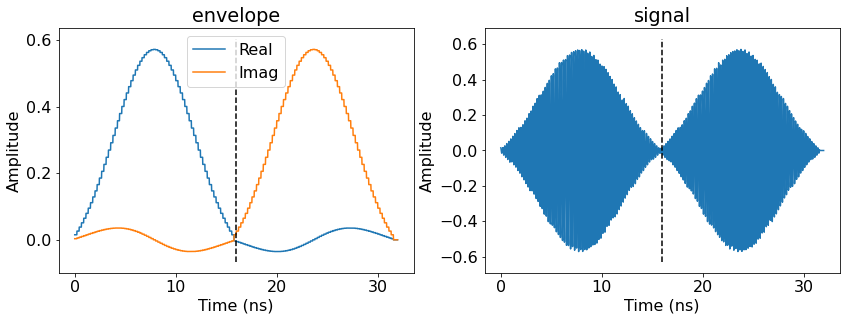

In [2]:
from matplotlib import pyplot as plt
from qiskit_dynamics.pulse import InstructionToSignals

plt.rcParams["font.size"] = 16

converter = InstructionToSignals(dt, carriers={"d0": w})

signals = converter.get_signals(xp)
fig, axs = plt.subplots(1, 2, figsize=(14, 4.5))
for ax, title in zip(axs, ["envelope", "signal"]):
    signals[0].draw(0, 2*T, 2000, title, axis=ax)
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("Amplitude")
    ax.set_title(title)
    ax.vlines(T, ax.get_ylim()[0], ax.get_ylim()[1], "k", linestyle="dashed")

In [3]:
from qiskit.quantum_info.operators import Operator
from qiskit_dynamics import Solver

# construct operators
X = Operator.from_label('X')
Z = Operator.from_label('Z')

drift = 2 * np.pi * w * Z/2
operators = [2 * np.pi * r * X/2]

# construct the solver
hamiltonian_solver = Solver(
    static_hamiltonian=drift,
    hamiltonian_operators=operators,
    rotating_frame=drift,
    rwa_cutoff_freq=2 * 5.0,
    hamiltonian_channels=['d0'],
    channel_carrier_freqs={'d0': w},
    dt=dt
)

In [4]:
from qiskit.quantum_info.states import Statevector

# Start the qubit in its ground state.
y0 = Statevector([1., 0.])

%time sol = hamiltonian_solver.solve(t_span=[0., 2*T], y0=y0, signals=xp, atol=1e-8, rtol=1e-8)

CPU times: total: 9.17 s
Wall time: 9.35 s


In [5]:
def plot_populations(sol):
    pop0 = [psi.probabilities()[0] for psi in sol.y]
    pop1 = [psi.probabilities()[1] for psi in sol.y]

    fig = plt.figure(figsize=(8, 5))
    plt.plot(sol.t, pop0, lw=3, label="Population in |0>")
    plt.plot(sol.t, pop1, lw=3, label="Population in |1>")
    plt.xlabel("Time (ns)")
    plt.ylabel("Population")
    plt.legend(frameon=False)
    plt.ylim([0, 1.05])
    plt.xlim([0, 2*T])
    plt.vlines(T, 0, 1.05, "k", linestyle="dashed")

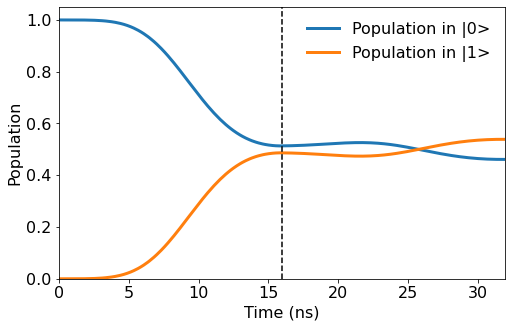

In [6]:
plot_populations(sol)